# NHANES Consolidated Data - Exploratory Data Analysis (EDA)

Análisis exploratorio del dataset consolidado NHANES con nombres legibles.

**Dataset**: NHANES_consolidated.parquet
- Target: glucose_class (normal, prediabetes, diabetes)

In [31]:
# === IMPORTS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Configurar estilo
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load Data

In [32]:
# Cargar el dataset consolidado
df = pd.read_parquet('../data/nhanes_data/NHANES_consolidated.parquet')

print(f"Dataset shape: {df.shape}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset shape: (57395, 21)

Memory usage: 8.81 MB


## 2. Dataset Overview

In [33]:
# Basic info
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nShape: {df.shape}")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")

print(f"\nData types:")
print(df.dtypes)

print(f"\nColumns:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

DATASET OVERVIEW

Shape: (57395, 21)
Rows: 57,395
Columns: 21

Data types:
subject_id               float64
creatinine               float64
bmi                      float64
waist_cm                 float64
weight_kg                float64
height_cm                float64
hypertension             float64
BPX_SYS                  float64
BPX_DIA                  float64
age_years                float64
gender                   float64
ethnicity                float64
income_poverty_ratio     float64
hdl_cholesterol          float64
liber_disease            float64
heart_disease            float64
SLQ                      float64
smoker                   float64
total_cholesterol        float64
TRIGLY                   float64
glucose_class           category
dtype: object

Columns:
   1. subject_id
   2. creatinine
   3. bmi
   4. waist_cm
   5. weight_kg
   6. height_cm
   7. hypertension
   8. BPX_SYS
   9. BPX_DIA
  10. age_years
  11. gender
  12. ethnicity
  13. income_poverty_rati

## 3. Missing Values Analysis


MISSING VALUES ANALYSIS

Missing values by column:
              Column  Missing_Count  Missing_%
              TRIGLY          40369      70.34
       glucose_class          39802      69.35
       heart_disease          23309      40.61
       liber_disease          23309      40.61
          creatinine          22810      39.74
              smoker          21903      38.16
                 SLQ          19981      34.81
        hypertension          19737      34.39
             BPX_SYS          18453      32.15
             BPX_DIA          18453      32.15
     hdl_cholesterol          17808      31.03
   total_cholesterol          17809      31.03
            waist_cm          11453      19.95
                 bmi           9374      16.33
           height_cm           9288      16.18
income_poverty_ratio           6919      12.06
           weight_kg           6155      10.72
          subject_id              0       0.00
           ethnicity              0       0.00
        

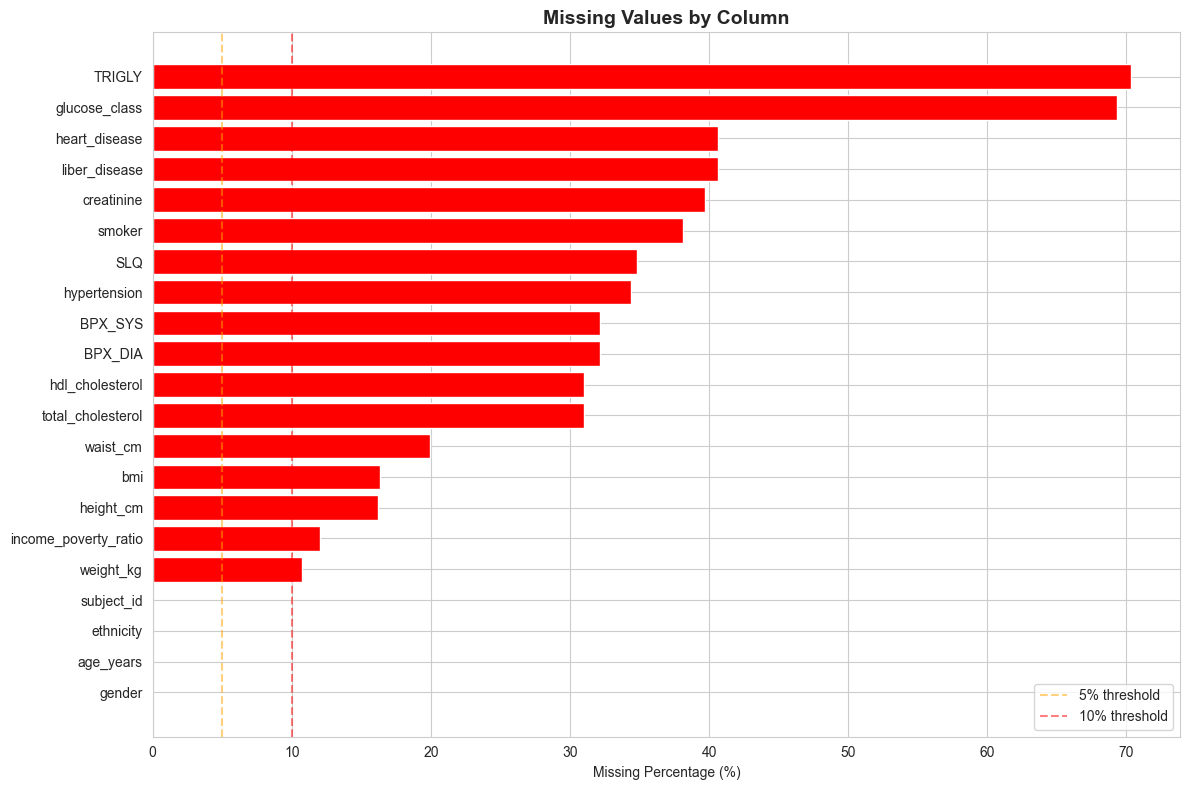


Total missing cells: 326,932
Total cells: 1,205,295
Overall missing %: 27.12%


In [34]:
# Missing values analysis
print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)

missing = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_%': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_%', ascending=False)

print("\nMissing values by column:")
print(missing.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
missing_sorted = missing.sort_values('Missing_%')
colors = ['red' if x > 10 else 'orange' if x > 5 else 'green' for x in missing_sorted['Missing_%']]
ax.barh(missing_sorted['Column'], missing_sorted['Missing_%'], color=colors)
ax.set_xlabel('Missing Percentage (%)')
ax.set_title('Missing Values by Column', fontsize=14, fontweight='bold')
ax.axvline(x=5, color='orange', linestyle='--', alpha=0.5, label='5% threshold')
ax.axvline(x=10, color='red', linestyle='--', alpha=0.5, label='10% threshold')
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nTotal missing cells: {df.isnull().sum().sum():,}")
print(f"Total cells: {df.shape[0] * df.shape[1]:,}")
print(f"Overall missing %: {df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100:.2f}%")

## 4. Target Variable Analysis


TARGET VARIABLE: glucose_class

Distribution:
  normal         :  8,591 ( 15.0%)
  prediabetes    :  6,890 ( 12.0%)
  diabetes       :  2,112 (  3.7%)
  Missing        : 39,802 ( 69.3%)


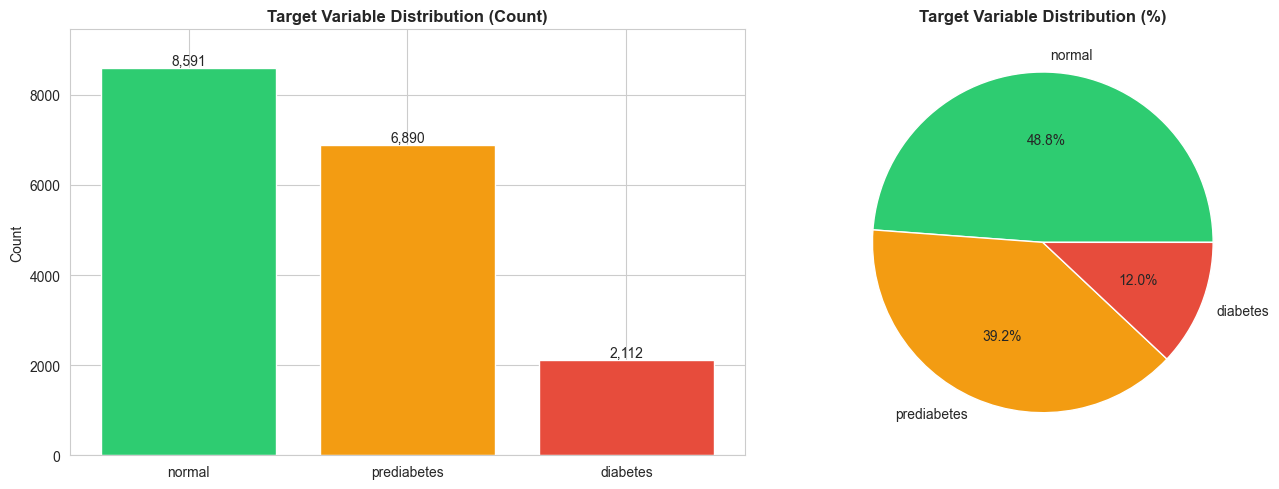


Class imbalance ratio (Normal/Diabetes): 4.07:1


In [35]:
# Target variable distribution
print("\n" + "="*80)
print("TARGET VARIABLE: glucose_class")
print("="*80)

target_dist = df['glucose_class'].value_counts(dropna=False)
target_pct = df['glucose_class'].value_counts(normalize=True, dropna=False) * 100

print("\nDistribution:")
for cls in ['normal', 'prediabetes', 'diabetes', np.nan]:
    if cls in target_dist.index or pd.isna(cls):
        count = target_dist.get(cls, 0)
        pct = target_pct.get(cls, 0) if not pd.isna(cls) else (df['glucose_class'].isnull().sum() / len(df) * 100)
        label = 'Missing' if pd.isna(cls) else cls
        print(f"  {label:15s}: {count:6,} ({pct:5.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
target_counts = df['glucose_class'].value_counts().sort_index()
colors_class = {'normal': '#2ecc71', 'prediabetes': '#f39c12', 'diabetes': '#e74c3c'}
ax = axes[0]
bars = ax.bar(target_counts.index, target_counts.values, 
               color=[colors_class.get(x, '#95a5a6') for x in target_counts.index])
ax.set_ylabel('Count')
ax.set_title('Target Variable Distribution (Count)', fontsize=12, fontweight='bold')
ax.set_ylim(0, target_counts.max() * 1.1)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{int(height):,}', ha='center', va='bottom', fontsize=10)

# Pie chart
ax = axes[1]
target_counts.plot(kind='pie', ax=ax, autopct='%1.1f%%', 
                   colors=[colors_class.get(x, '#95a5a6') for x in target_counts.index])
ax.set_ylabel('')
ax.set_title('Target Variable Distribution (%)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Class imbalance
normal_pct = (target_counts['normal'] / target_counts.sum()) * 100
diabetes_pct = (target_counts['diabetes'] / target_counts.sum()) * 100
imbalance_ratio = target_counts['normal'] / target_counts['diabetes']
print(f"\nClass imbalance ratio (Normal/Diabetes): {imbalance_ratio:.2f}:1")

## 5. Demographic Variables Analysis


DEMOGRAPHIC VARIABLES ANALYSIS

1. AGE (age_years):
count    57395.000000
mean        33.575468
std         25.135599
min          0.000000
25%         10.000000
50%         30.000000
75%         56.000000
max         80.000000
Name: age_years, dtype: float64

2. GENDER (1=Male, 2=Female):
gender
1.0    28047
2.0    29348
Name: count, dtype: int64

Percentage:
  Male (1):   48.9%
  Female (2): 51.1%

3. ETHNICITY (RIDRETH1 codes):
  1.0 - Mexican American         :  8,113 ( 14.1%)
  2.0 - Other Hispanic           :  6,261 ( 10.9%)
  3.0 - Non-Hispanic White       : 21,201 ( 36.9%)
  4.0 - Non-Hispanic Black       : 12,774 ( 22.3%)
  5.0 - Other/Multiracial        :  9,046 ( 15.8%)


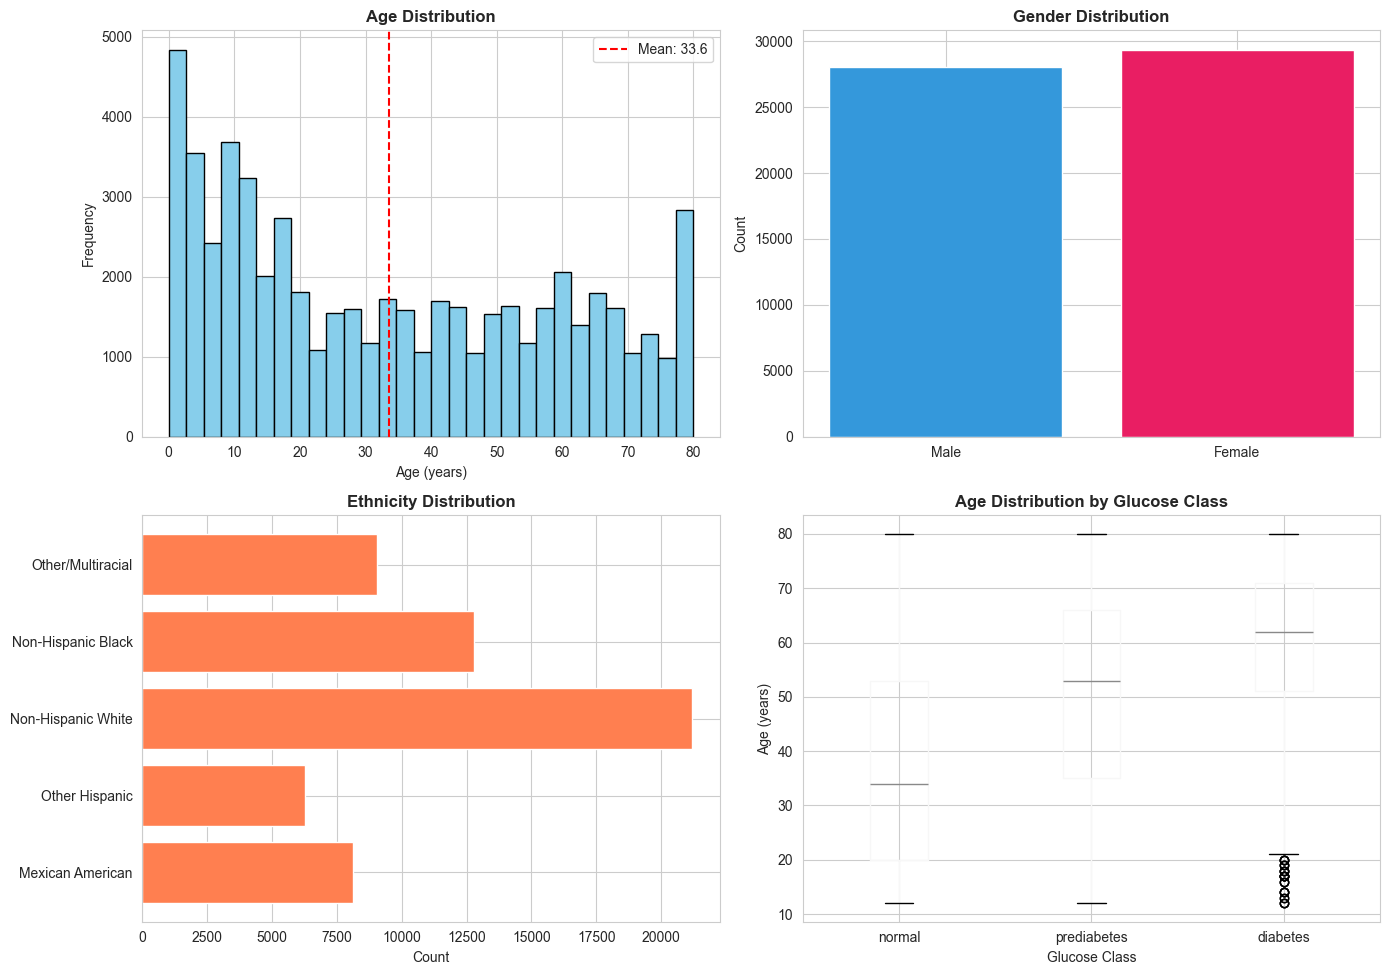

In [36]:
print("\n" + "="*80)
print("DEMOGRAPHIC VARIABLES ANALYSIS")
print("="*80)

# Age analysis
print("\n1. AGE (age_years):")
print(df['age_years'].describe())

# Gender analysis
print("\n2. GENDER (1=Male, 2=Female):")
print(df['gender'].value_counts().sort_index())
gender_pct = df['gender'].value_counts(normalize=True).sort_index() * 100
print(f"\nPercentage:")
print(f"  Male (1):   {gender_pct.get(1, 0):.1f}%")
print(f"  Female (2): {gender_pct.get(2, 0):.1f}%")

# Ethnicity analysis
print("\n3. ETHNICITY (RIDRETH1 codes):")
ethnicity_map = {
    1: 'Mexican American',
    2: 'Other Hispanic',
    3: 'Non-Hispanic White',
    4: 'Non-Hispanic Black',
    5: 'Other/Multiracial'
}
eth_counts = df['ethnicity'].value_counts().sort_index()
for code, count in eth_counts.items():
    name = ethnicity_map.get(code, f'Code {code}')
    pct = count / len(df) * 100
    print(f"  {code} - {name:25s}: {count:6,} ({pct:5.1f}%)")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution
axes[0, 0].hist(df['age_years'].dropna(), bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Age (years)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Age Distribution', fontweight='bold')
axes[0, 0].axvline(df['age_years'].mean(), color='red', linestyle='--', label=f'Mean: {df["age_years"].mean():.1f}')
axes[0, 0].legend()

# Gender distribution
gender_counts = df['gender'].value_counts()
gender_labels = [f'Male ({gender_counts.get(1, 0):,})', f'Female ({gender_counts.get(2, 0):,})']
axes[0, 1].bar(['Male', 'Female'], [gender_counts.get(1, 0), gender_counts.get(2, 0)], color=['#3498db', '#e91e63'])
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Gender Distribution', fontweight='bold')

# Ethnicity distribution
eth_labels = [ethnicity_map.get(code, f'Code {code}') for code in eth_counts.index]
axes[1, 0].barh(eth_labels, eth_counts.values, color='coral')
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_title('Ethnicity Distribution', fontweight='bold')

# Age by glucose class
df.boxplot(column='age_years', by='glucose_class', ax=axes[1, 1])
axes[1, 1].set_xlabel('Glucose Class')
axes[1, 1].set_ylabel('Age (years)')
axes[1, 1].set_title('Age Distribution by Glucose Class', fontweight='bold')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

## 6. Anthropometric Variables Analysis


ANTHROPOMETRIC VARIABLES ANALYSIS

BMI:
count    48021.00
mean        26.22
std          8.10
min         11.10
25%         20.20
50%         25.40
75%         30.80
max         92.30
Name: bmi, dtype: float64

HEIGHT_CM:
count    48107.00
mean       156.49
std         22.61
min         78.30
25%        150.90
50%        162.20
75%        171.30
max        204.50
Name: height_cm, dtype: float64

WEIGHT_KG:
count    51240.00
mean        64.52
std         32.35
min          2.70
25%         42.30
50%         67.20
75%         85.20
max        254.30
Name: weight_kg, dtype: float64

WAIST_CM:
count    45942.00
mean        88.74
std         22.73
min         38.70
25%         72.80
50%         89.70
75%        104.20
max        187.50
Name: waist_cm, dtype: float64


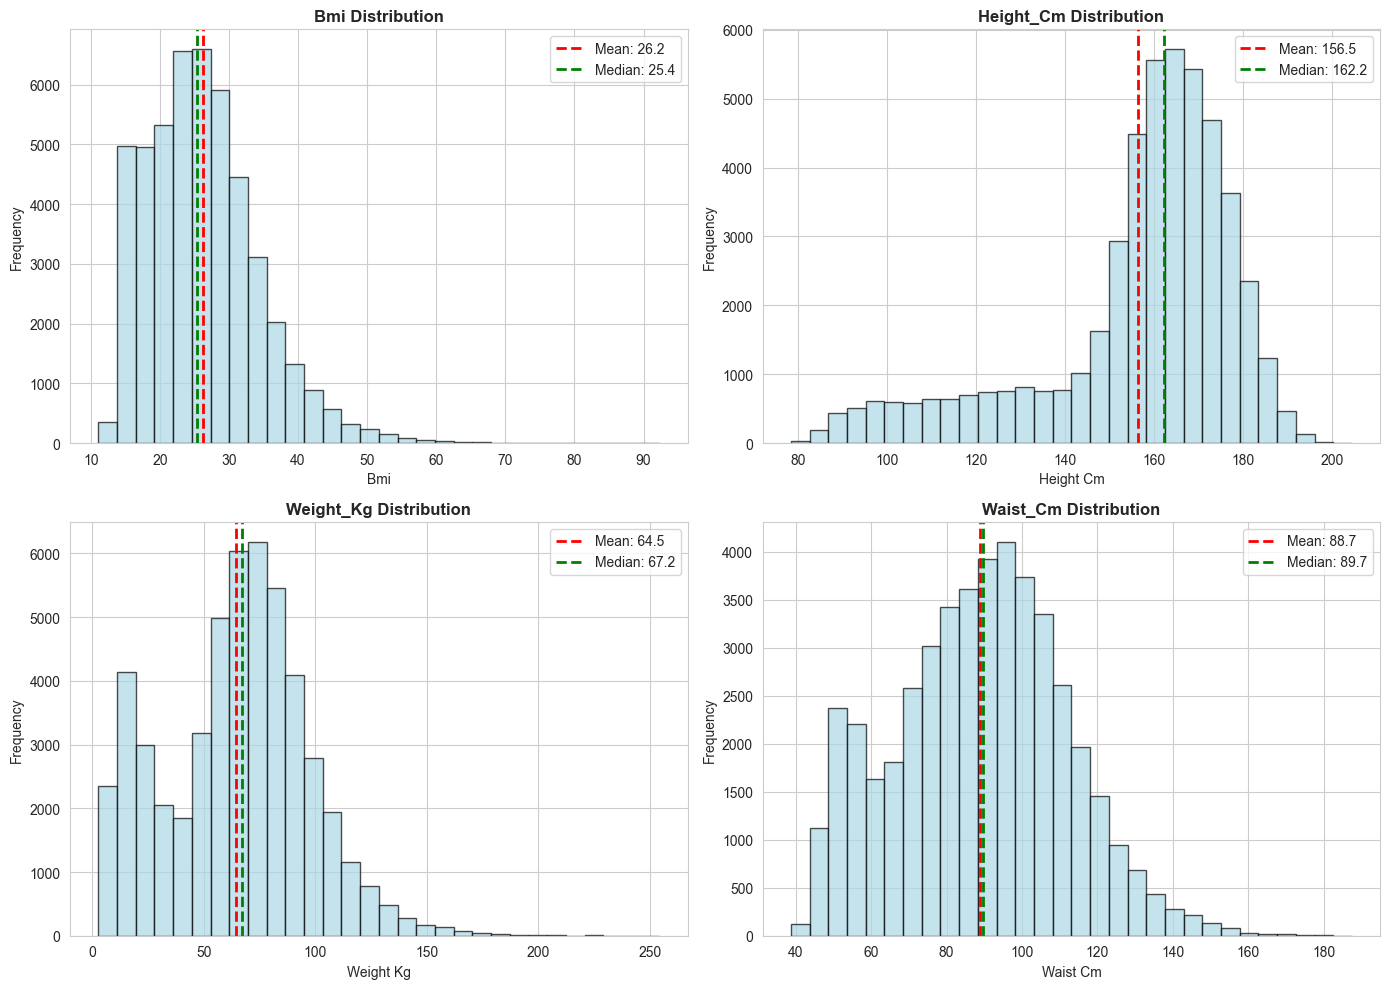


Correlation Matrix:
             bmi  height_cm  weight_kg  waist_cm
bmi        1.000      0.498      0.915     0.934
height_cm  0.498      1.000      0.776     0.679
weight_kg  0.915      0.776      1.000     0.950
waist_cm   0.934      0.679      0.950     1.000


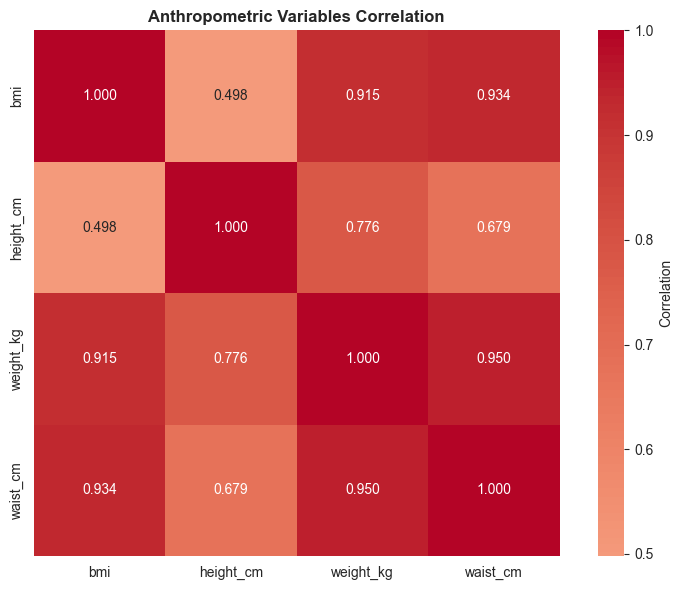

In [37]:
print("\n" + "="*80)
print("ANTHROPOMETRIC VARIABLES ANALYSIS")
print("="*80)

anthro_vars = ['bmi', 'height_cm', 'weight_kg', 'waist_cm']

for var in anthro_vars:
    if var in df.columns:
        print(f"\n{var.upper()}:")
        print(df[var].describe().round(2))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, var in enumerate(anthro_vars):
    if var in df.columns:
        ax = axes[idx]
        
        # Histogram
        ax.hist(df[var].dropna(), bins=30, color='lightblue', edgecolor='black', alpha=0.7)
        ax.set_xlabel(var.replace('_', ' ').title())
        ax.set_ylabel('Frequency')
        ax.set_title(f'{var.title()} Distribution', fontweight='bold')
        ax.axvline(df[var].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[var].mean():.1f}')
        ax.axvline(df[var].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df[var].median():.1f}')
        ax.legend()

plt.tight_layout()
plt.show()

# Correlations between anthropometric variables
anthro_corr = df[anthro_vars].corr()
print("\nCorrelation Matrix:")
print(anthro_corr.round(3))

# Visualize correlation
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(anthro_corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Anthropometric Variables Correlation', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Clinical Variables Analysis


CLINICAL VARIABLES ANALYSIS

TOTAL_CHOLESTEROL:
count    39586.00
mean       180.10
std         41.23
min         59.00
25%        151.00
50%        176.00
75%        205.00
max        813.00
Name: total_cholesterol, dtype: float64

HDL_CHOLESTEROL:
count    39587.00
mean        53.53
std         15.04
min          5.00
25%         43.00
50%         51.00
75%         62.00
max        226.00
Name: hdl_cholesterol, dtype: float64

CREATININE:
count    34585.00
mean         0.87
std          0.44
min          0.16
25%          0.68
50%          0.82
75%          0.98
max         17.41
Name: creatinine, dtype: float64


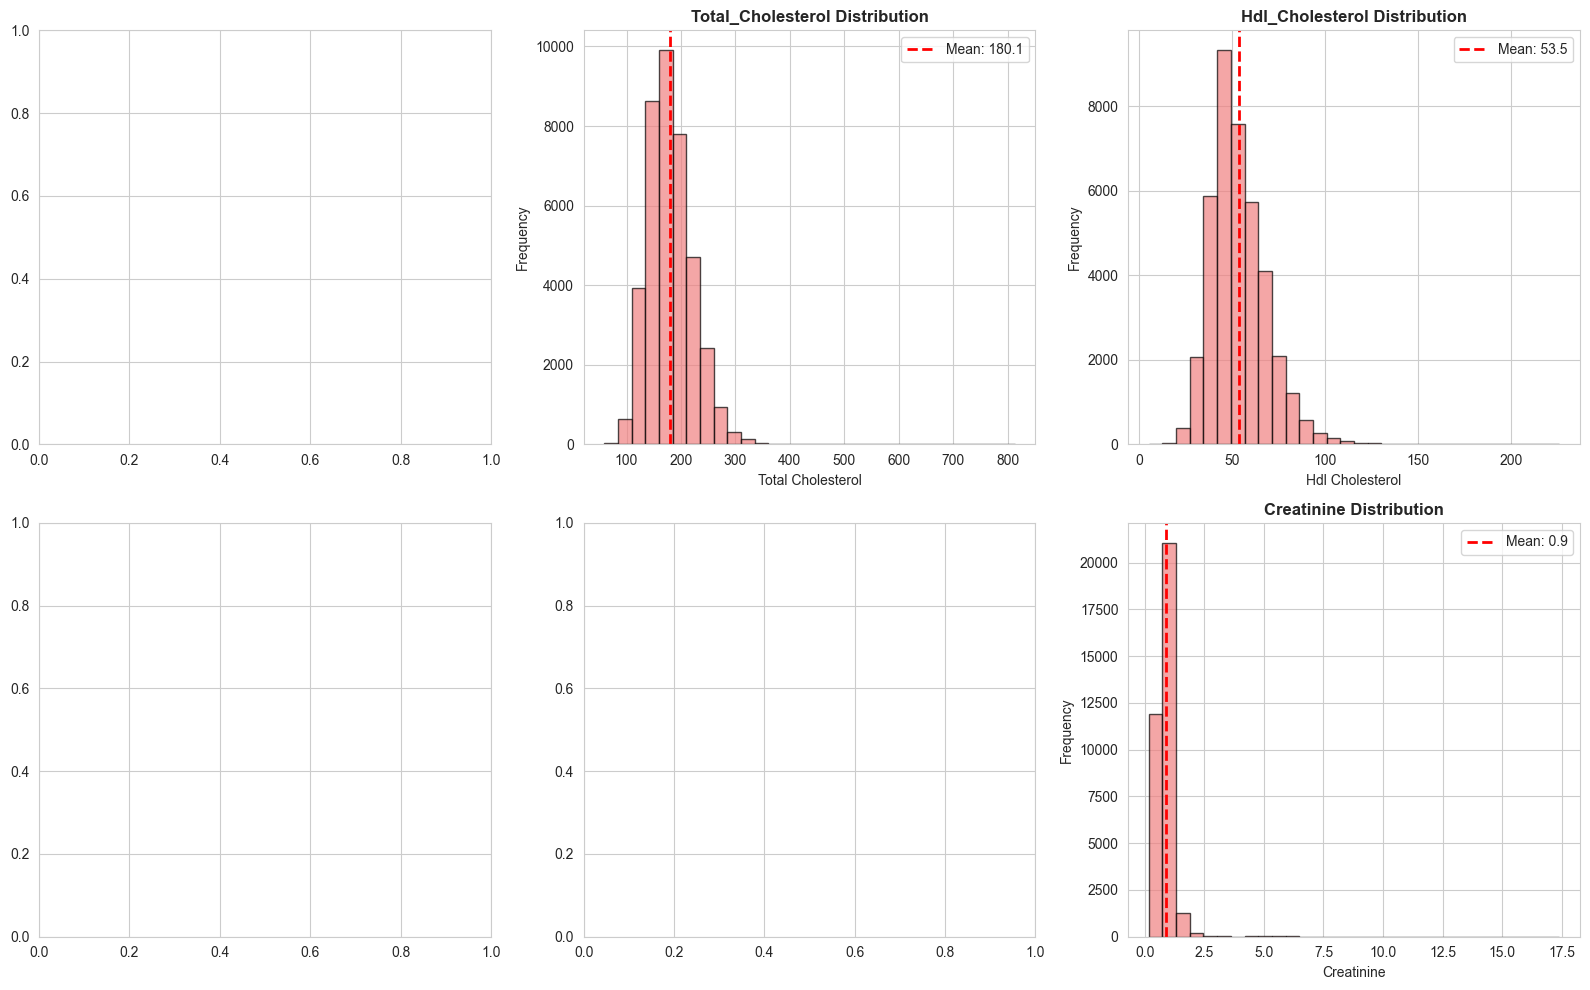

In [38]:
print("\n" + "="*80)
print("CLINICAL VARIABLES ANALYSIS")
print("="*80)

clinical_vars = ['triglycerides', 'total_cholesterol', 'hdl_cholesterol', 
                 'systolic_bp', 'diastolic_bp', 'creatinine']

for var in clinical_vars:
    if var in df.columns:
        print(f"\n{var.upper()}:")
        print(df[var].describe().round(2))

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, var in enumerate(clinical_vars):
    if var in df.columns:
        ax = axes[idx]
        
        ax.hist(df[var].dropna(), bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
        ax.set_xlabel(var.replace('_', ' ').title())
        ax.set_ylabel('Frequency')
        ax.set_title(f'{var.title()} Distribution', fontweight='bold')
        ax.axvline(df[var].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[var].mean():.1f}')
        ax.legend()

plt.tight_layout()
plt.show()

## 8. Consolidated Variables Analysis

In [39]:
print("\n" + "="*80)
print("CONSOLIDATED VARIABLES (Merged from Multiple Sources)")
print("="*80)

consolidated_vars = {
    'triglycerides': 'LBXTR + LBXTGL',
    'sleep_hours': 'SLD010H + SLD012',
    'systolic_bp': 'BPXSY1 + BPXOSY1',
    'diastolic_bp': 'BPXDI1 + BPXODI1'
}

print("\nConsolidation Status:")
for consolidated, original in consolidated_vars.items():
    if consolidated in df.columns:
        count = df[consolidated].notna().sum()
        pct = count / len(df) * 100
        print(f"  {consolidated:20s} ({original:20s}): {count:6,} values ({pct:5.1f}%)")

# Check for duplicates
print("\n✓ Verification: No original duplicate columns:")
original_cols = ['LBXTR', 'LBXTGL', 'SLD010H', 'SLD012', 'BPXSY1', 'BPXOSY1', 'BPXDI1', 'BPXODI1']
found_original = [col for col in original_cols if col in df.columns]
if not found_original:
    print("  All original columns have been consolidated")
else:
    print(f"  WARNING: Found original columns: {found_original}")


CONSOLIDATED VARIABLES (Merged from Multiple Sources)

Consolidation Status:

✓ Verification: No original duplicate columns:
  All original columns have been consolidated


## 9. Relationship with Target Variable


RELATIONSHIP WITH TARGET VARIABLE (glucose_class)

Correlation with Target Variable:
             Feature  Correlation
           age_years     0.385158
            waist_cm     0.366210
             BPX_SYS     0.273557
                 bmi     0.272741
           weight_kg     0.264909
        hypertension    -0.261192
              TRIGLY     0.235767
     hdl_cholesterol    -0.189725
             BPX_DIA     0.135556
              gender    -0.133019
          creatinine     0.091873
              smoker    -0.083582
   total_cholesterol     0.057902
       heart_disease    -0.056023
           ethnicity    -0.048579
           height_cm     0.043988
       liber_disease    -0.033123
                 SLQ     0.008663
income_poverty_ratio    -0.002326


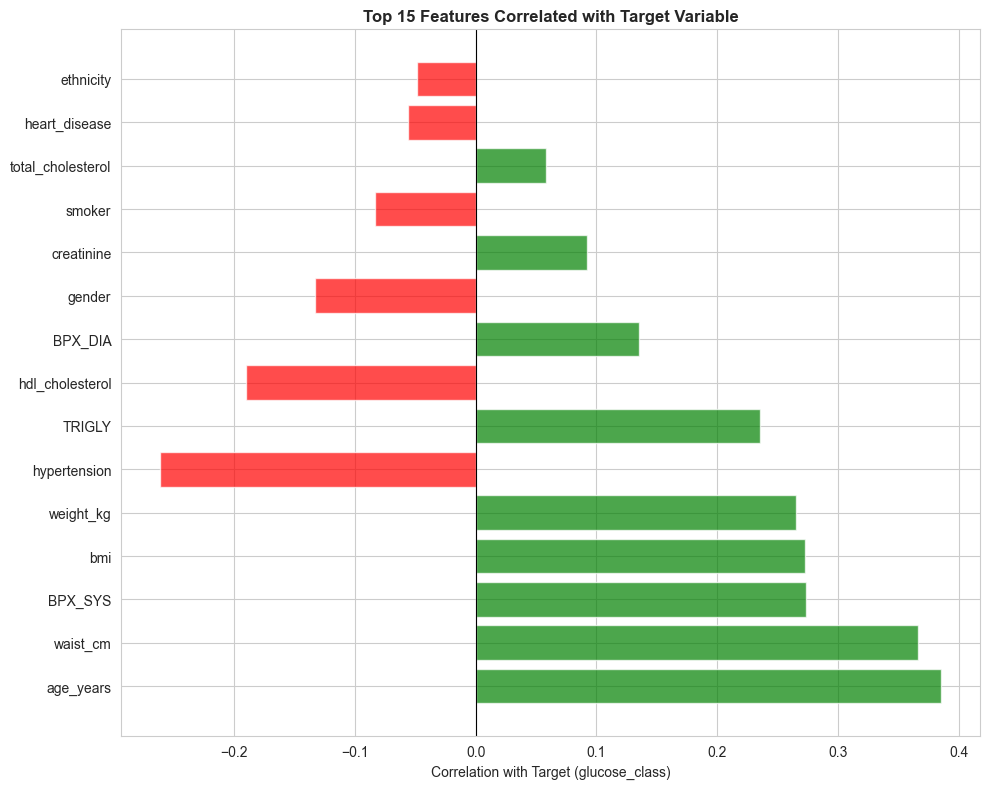

In [40]:
print("\n" + "="*80)
print("RELATIONSHIP WITH TARGET VARIABLE (glucose_class)")
print("="*80)

# Select numeric features (excluding subject_id)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'subject_id']

# Calculate correlation with target (encode target)
target_encoding = {'normal': 0, 'prediabetes': 1, 'diabetes': 2}
df['target_encoded'] = df['glucose_class'].map(target_encoding)

# Correlation analysis
correlations = []
for col in numeric_cols:
    if df[col].notna().sum() > 0:
        corr = df[col].corr(df['target_encoded'])
        correlations.append({'Feature': col, 'Correlation': corr})

corr_df = pd.DataFrame(correlations).sort_values('Correlation', key=abs, ascending=False)
print("\nCorrelation with Target Variable:")
print(corr_df.to_string(index=False))

# Visualize top correlations
fig, ax = plt.subplots(figsize=(10, 8))
top_corr = corr_df.head(15)
colors = ['red' if x < 0 else 'green' for x in top_corr['Correlation']]
ax.barh(top_corr['Feature'], top_corr['Correlation'], color=colors, alpha=0.7)
ax.set_xlabel('Correlation with Target (glucose_class)')
ax.set_title('Top 15 Features Correlated with Target Variable', fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.show()

# Remove encoding
df.drop('target_encoded', axis=1, inplace=True)

## 10. Statistical Tests

In [41]:
print("\n" + "="*80)
print("STATISTICAL TESTS")
print("="*80)

# Test for normality (Shapiro-Wilk)
print("\n1. NORMALITY TEST (Shapiro-Wilk p-values):")
print("   Note: Small sample test on 5000 random samples due to dataset size")

normality_results = []
sample_size = min(5000, len(df))
for col in numeric_cols:
    if df[col].notna().sum() >= 3:
        sample = df[col].dropna().sample(min(sample_size, df[col].notna().sum()), random_state=42)
        stat, p_value = stats.shapiro(sample)
        is_normal = 'Yes' if p_value > 0.05 else 'No'
        normality_results.append({'Feature': col, 'p-value': p_value, 'Normal': is_normal})

normality_df = pd.DataFrame(normality_results).sort_values('p-value', ascending=False)
print(normality_df.to_string(index=False))

# ANOVA test for differences between groups
print("\n2. ANOVA TEST (p-values for differences between glucose classes):")

anova_results = []
for col in numeric_cols:
    groups = [group[col].dropna().values for name, group in df.groupby('glucose_class')]
    if len(groups) > 1 and all(len(g) > 1 for g in groups):
        f_stat, p_value = stats.f_oneway(*groups)
        is_significant = 'Yes' if p_value < 0.05 else 'No'
        anova_results.append({'Feature': col, 'p-value': p_value, 'Significant': is_significant})

anova_df = pd.DataFrame(anova_results).sort_values('p-value')
print(anova_df.to_string(index=False))


STATISTICAL TESTS

1. NORMALITY TEST (Shapiro-Wilk p-values):
   Note: Small sample test on 5000 random samples due to dataset size
             Feature      p-value Normal
            waist_cm 5.417578e-20     No
   total_cholesterol 2.381684e-28     No
           weight_kg 2.541113e-29     No
                 bmi 9.937803e-37     No
             BPX_DIA 3.615271e-37     No
     hdl_cholesterol 4.434726e-39     No
             BPX_SYS 1.368917e-39     No
           age_years 7.771971e-46     No
           ethnicity 4.023477e-49     No
income_poverty_ratio 1.324765e-49     No
           height_cm 1.655128e-53     No
              gender 2.097697e-73     No
              smoker 1.575891e-74     No
          creatinine 9.167340e-76     No
        hypertension 7.691982e-79     No
              TRIGLY 1.101720e-81     No
                 SLQ 2.686269e-83     No
       heart_disease 5.981384e-92     No
       liber_disease 3.825807e-92     No

2. ANOVA TEST (p-values for differences betwee

## 11. Data Quality Summary

In [42]:
print("\n" + "="*80)
print("DATA QUALITY SUMMARY")
print("="*80)

# Overall statistics
print(f"\nDataset Size:")
print(f"  Rows: {len(df):,}")
print(f"  Columns: {len(df.columns)}")
print(f"  Total cells: {len(df) * len(df.columns):,}")

# Missing data
total_missing = df.isnull().sum().sum()
total_cells = len(df) * len(df.columns)
missing_pct = (total_missing / total_cells) * 100

print(f"\nMissing Data:")
print(f"  Total missing cells: {total_missing:,}")
print(f"  Overall missing %: {missing_pct:.2f}%")
print(f"  Columns with <5% missing: {len(missing[missing['Missing_%'] < 5])}")
print(f"  Columns with 5-10% missing: {len(missing[(missing['Missing_%'] >= 5) & (missing['Missing_%'] < 10)])}")
print(f"  Columns with >10% missing: {len(missing[missing['Missing_%'] >= 10])}")

# Data types
print(f"\nData Types:")
print(f"  Numeric columns: {len(df.select_dtypes(include=[np.number]).columns)}")
print(f"  Object columns: {len(df.select_dtypes(include=['object']).columns)}")
print(f"  Category columns: {len(df.select_dtypes(include=['category']).columns)}")

# Duplicates
print(f"\nDuplicate Rows:")
print(f"  Total duplicates: {len(df[df.duplicated(subset=['subject_id'])])}")
print(f"  Unique subject_ids: {df['subject_id'].nunique():,}")

# Target variable
print(f"\nTarget Variable (glucose_class):")
print(f"  Valid values: {df['glucose_class'].notna().sum():,}")
print(f"  Missing: {df['glucose_class'].isnull().sum():,}")
print(f"  Classes: {df['glucose_class'].nunique()}")
print(f"  Class balance: Acceptable" if all((df['glucose_class'].value_counts() / len(df) > 0.1).values) else "  Class balance Imbalanced")

print(f"\nEDA Complete!")


DATA QUALITY SUMMARY

Dataset Size:
  Rows: 57,395
  Columns: 21
  Total cells: 1,205,295

Missing Data:
  Total missing cells: 326,932
  Overall missing %: 27.12%
  Columns with <5% missing: 4
  Columns with 5-10% missing: 0
  Columns with >10% missing: 17

Data Types:
  Numeric columns: 20
  Object columns: 0
  Category columns: 1

Duplicate Rows:
  Total duplicates: 0
  Unique subject_ids: 57,395

Target Variable (glucose_class):
  Valid values: 17,593
  Missing: 39,802
  Classes: 3
  Class balance Imbalanced

EDA Complete!
